# Cleverly Challenge

This works as my submission of the cleverly challenge.
The challenge consists in the [Amazon products review dataset](http://jmcauley.ucsd.edu/data/amazon/) (Clothing, Shoes and Jewlry)

This dataset consists 278677 reviews about these types of items where each row in the dataset has the followng information:
- reviewrID - ID of the reviewer (39387 unique values)
- asin - ID of the product (23033 unique values)
- reviewerName - name of the reviewer
- helpful - a tuple containing the number of "Yes" votes, and the total number of votes
- reviewText - The main body text of the review
- overall - The rating the user gave the product
- summary - A short summary of the review
- UnixReviewTime - Unix timestamp of the review
- reviewTime - Time of the review (raw)

## Importante: 
- Hugging faces transformers requires TF 2.0 or pytorch
- Tambem preciso de fazer aquilo de fazer download das cenas do nltk
`import nltk; nltk.download('stopwords')`

Ver quais é que são as palavras mais frequentes nem perguntas uteis (e em perguntas que tenham tipo rating de 5) (lembrar de tirar stopwords, fazer lemmantization, stemming, etc)
    Posso fazer um wordcloud disto por exemplo
    Ver também com o TF-IDF para conseguir perceber a "novelty" dessas palavras
    
Questions:

Is there a correlation between rating of the product and helpfulness of review?
    Aqui posso tentar 3 coisas:
        - Tentar ver isto tambem com anova ? https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection


In [115]:
# Install HuggingFace's transformer packages to use DistilBert
!pip install transformers
#!pip install tensorflow
#!pip install torch
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp37-none-any.whl size=884633 sha256=c94fc80871328531f123627eed25b2ddb62c97d93193ec2cf316f5a1a1deb760
  Stored in directory: C:\Users\lsfischer\AppData\Local\pip\Cache\wheels\6d\ec\1a\21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [1]:
# importing required libraries
import ast # for evaluating string representation of lists
import string
import itertools # for chaining ranges 
import transformers # for using DistilBert
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# loading the dataset
df = pd.read_csv("../data/Clothing_Shoes_and_Jewelry_5.csv")

# quick check of the data
print(df.shape)
df.head()

I0220 20:50:48.249598 140592964134720 file_utils.py:57] TensorFlow version 2.1.0 available.


(278677, 9)


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000031887,"[0, 0]",5,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600
3,0000031887,"[0, 0]",5,"We bought several tutus at once, and they are ...","04 27, 2014",A8U3FAMSJVHS5,Caromcg,"Adorable, Sturdy",1398556800
4,0000031887,"[0, 0]",5,Thank you Halo Heaven great product for Little...,"03 15, 2014",A3GEOILWLK86XM,CJ,Grammy's Angels Love it,1394841600


# Pre-processing the data
Here the main bulk of work is done to pre-process the data. This consists in cleaning the text columns, converting date columns to datetime objects, creating the binary target variable indicating if a review is helpful and adding a few new features

It is always good to first check on missing values so as to know if this might be a problem or not

In [2]:
df.isna().sum()

asin                0
helpful             0
overall             0
reviewText         24
reviewTime          0
reviewerID          0
reviewerName      469
summary             1
unixReviewTime      0
dtype: int64

There are few missing values in the dataset, with most of them beeing in the reviewers name, which we might even discard this feature so no harm done there.

The `reviewText` column has 24 missing values (a small portion) which could just be discarded. However, looking at these rows we see that even though they don't have `reviewText` they still have the `summary` column, which we can still use to get some insight.

Anyways we're going to replace this `NaN`'s with empty strings so we can interpret the entire column as a string. But first let's quickly convert the date column to a datetime object for easy manipulation

In [3]:
# Convert unix timestamp to datetime object
df["reviewTime"] = pd.to_datetime(df["unixReviewTime"], unit="s")
df.drop("unixReviewTime", axis=1, inplace=True)

# Checking the rows in which the reviewText is not present. They don't have reviewTime but they at least have the summary
df.loc[df["reviewText"].isna(), ["reviewText", "summary"]]

Looking at this segment of the data we notice that the `reviewerName` of index 1806 has a non-ascii character. It might be best to remove this characters all together.

Lets also remove punctiation and stopwords from `reviewText` and `summary`. Stopwords are those common words that don't really add much to the sentece (e.g. the, a, etc.). Lemmatization (e.g. transforming "studying" to "study") and stemming is not yet applied here although this could be tested to see if it improves results

In [5]:
# This cell takes some time (around 1m30s) because in order to clean the sentence and remove the stopwords I'm iterating
# over every word in the sentece to check if it is a stop-word. Maybe a better solution would be needed for larger texts

# Replace NaN cells with empty strings
df = df.fillna("")

# Specify the non-ascii characters. Non ascii chars go from 0-31 and from 128-256
ascii_ranges = itertools.chain(range(32), range(128, 257))

# Create a lookup table specifying that non-ascii chars should be translated to empty strings
# This table will be fed to str.translate
# str.translate uses C-level table lookup so it's much faster than iterating over every char and replacing them
tbl = dict.fromkeys(ascii_ranges, u"")

# Create the english stop_words set
stop_words = set(stopwords.words('english'))

def clean_sentence(s):
    """
        Given a sentence remove its punctuation and stop words
        
        Arguments:
            s - the input string to clean
            
        Returns: The input string stripped out of punctuation and stopwords
    """
    s = s.lower().translate(tbl) # Remove non-ascii chars
    s = s.translate(str.maketrans('','',string.punctuation)) # remove punctuation
    tokens = word_tokenize(s)
    cleaned_s = [w for w in tokens if w not in stop_words] # removing stop-words
    return " ".join(cleaned_s)

# Apply clean_sentence to reviewText and summary; to reviewerName just remove non-ascii chars
df["reviewText"] = df["reviewText"].apply(clean_sentence)
df["summary"] = df["summary"].apply(clean_sentence)
df["reviewerName"] = df["reviewerName"].str.translate(tbl)

Let's also split up the helpfulness column into 3 different columns:
    - `num_yes_votes`: Number of "Yes" votes
    - `num_votes`: Total number of votes
    - `prop_yes_votes`: Proportion of "Yes" votes in the reiview
    
The `helpful` column is stored as the string representation of a list (from beeing stored in a `.csv` file). We first need to convert back to a list and then split the values of the list

Also add a new feature, `num_words`: the number of words present in the cleaned review text

In [6]:
# Evaluating the string representation of the list to convert it to an actual list
df["helpful"] = df["helpful"].apply(lambda str_list: ast.literal_eval(str_list))

# Split the helpful column into num_yes_votes and num_votes
# Splitting this way is faster the applying a fuction to every row to get the first and second element
df[['num_yes_votes','num_votes']] = pd.DataFrame(df["helpful"].values.tolist(), index= df.index)

# Creating the prop_yes_votes columns. Where there is no votes just leave at zero (avoid dividing by zero)
df["prop_yes_votes"] = np.where(df["num_votes"] == 0, 0, df["num_yes_votes"] / df["num_votes"])

# Count the number of words in the body
df["num_words"] = df["reviewText"].str.count("\w+")

# Task 1. Exploratory Data Analysis

This section is dedicated to answering high level questions about the data. This is useful to get familiar with the data and test some abstract hypothesis 

## Is there a correlation between the rating of the product and the helpfulness of the review?

When checking the correlation between features we need to take care to assure that pearson correlation makes sense to use. Trying to correlate a variable with a non-ordinal categorical variable doesn't really make sense and co-occurrence should be preferred. However in our case `helpful` (either number of "yes" votes or proportion of "yes" votes) is a numerical variable and `overvall` is ordinal given it has some intrisct order to it (a ratting of 5 is higher than a ratting of 1)

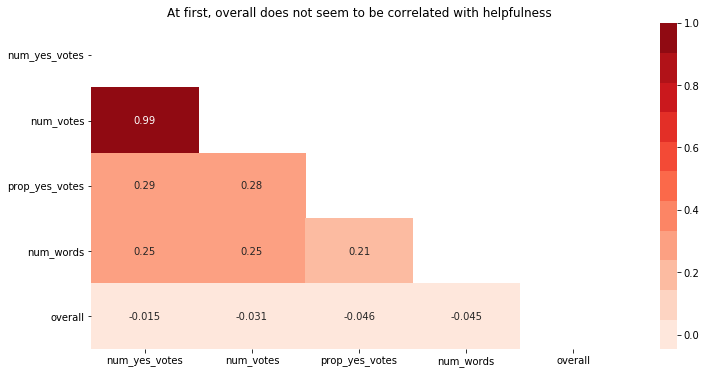

In [90]:
def plot_correlation_matrix(corr_matrix, plot_title=""):
    """
        Plot the lower triangle of the correlation matrix as a heatmap projection
        Arguments:
            corr_matrix: The correlation matrix to be plotted
            plot_title: The title of the plot
    """
    
    # Generate a mask to hide the upper triangle of the matrix
    mask = np.zeros_like(corr_matrix, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # plot the correalation matrix
    plt.figure(figsize=(12,6))
    sns.heatmap(corr_matrix, annot = True, cmap = sns.color_palette("Reds", 11), mask=mask)
    plt.title(plot_title)
    plt.show()
    
correlation = df[["num_yes_votes", "num_votes", "prop_yes_votes", "num_words", "overall"]].corr()
plot_correlation_matrix(correlation, 
                        plot_title="At first, overall does not seem to be correlated with helpfulness")

In [9]:
(df["num_votes"] == 0).value_counts()

True     191656
False     87021
Name: num_votes, dtype: int64

At first it does seem that the `overall` column is not really correlated in any way in the helpfulness of the review (ether it be the number of "yes" votes, the number of votes or the proportion of "yes" votes). However, 191656 reviews (68.77%) don't have a single vote, when we discard these reviews the correlation is different

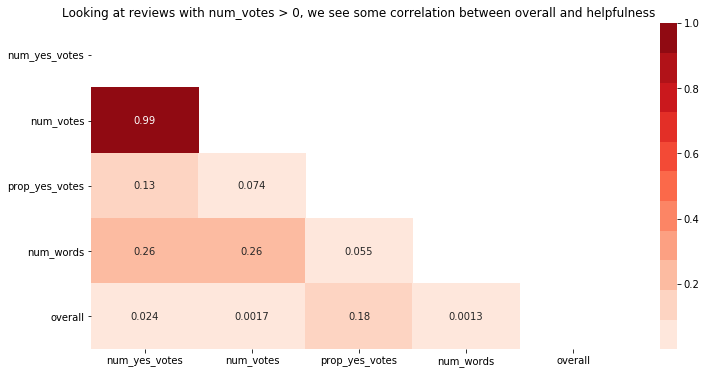

In [77]:
correlation_wout_zero_reviews = df.loc[df["num_votes"] != 0, ["num_yes_votes", "num_votes", "prop_yes_votes", "num_words", "overall"]].corr()
plot_correlation_matrix(correlation_wout_zero_reviews, 
                        plot_title="Looking at reviews with num_votes > 0, we see some correlation between overall and helpfulness")

When discarding reviews with no votes we see that there is a somewhat week correlation between `overall` and `prop_yes_votes`. This that the overall score is not really influenced by the number of "yes" votes, nor the total number of votes nor the number of words in the review. The overall score is, however, influenced by the proportion of "yes" votes the review have.

An interesting point is the correlation between `num_yes_votes` and `num_votes`. It is obivous that this correlation should be positive (since `num_yes_votes` is a subset of `num_votes`) however it is interesting that it has such a high correlation. This indicates that an user only votes in a review if it was actually helpful to them, and if it was not then he/she probably just ignores it.

## What is the median number of votes a review gets?

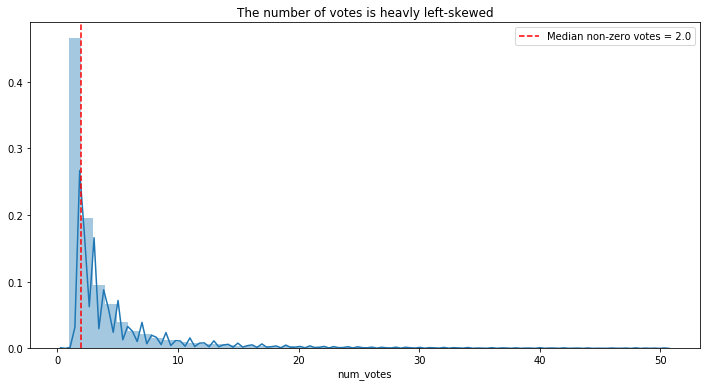

In [97]:
# Number of non-zero votes reviews = 87021

nonzero_votes_filtered = df.loc[(df["num_votes"] > 0) & (df["num_votes"] <= 50),  "num_votes"]
# nonzero_votes_filtered.shape[0] -> 86379

# 86379/87021 = 0.9926 -> 99% of non-zeros reviews have between 1 and 50 votes, so we can safely discard the rest for this analysis
plt.figure(figsize=(12,6))
sns.distplot(nonzero_votes_filtered)
plt.axvline(x=nonzero_votes_filtered.median(), color="red", ls="--", label=f"Median non-zero votes = {nonzero_votes_filtered.median()}")
plt.title("The number of votes is heavly left-skewed")
plt.legend()
plt.show()

Using the median is favoured over the average for skewed distributions such as this one because it is not as heavly influenced by outliers (extreme values)
So the median number of votes a review genereally gets is 2. Given this we can consider a helpfull review to have a high proportion of "yes" votes (let's say above 0.5) and also have more than, for example, two times the number of median votes.

Another possible way to find helpful reviews would be to for example weight the proportion of "yes" votes with the number of votes it has (`prop_yes_votes * num_votes`). All this approaches have some assumptions about them, picking one should be validated with stakeholders.

For the binary target variable indicating if a reviewing is helpful or not we'll define it as having more than 4 votes and having more "yes" votes than "not yes" votes. (`prop_yes_votes` >= 0.5)

In [29]:
# Creating the binary target label indicating if a review was helpful or not
df["helpful_review"] = ((df["num_votes"] >= 4) & (df["prop_yes_votes"] >= 0.5)).astype(int)
df["helpful_review"].value_counts()

0    256782
1     21895
Name: helpful_review, dtype: int64

Only 7.857% are considered helpful according to our definition of helpful reviews. Alhtough there is still a large number of positive class observations the is some class imbalance and so accuracy should be discouraged as a model evaluation metric

## Who are the most helpful reviewers?

Here we're defining the helpfulness score of a reviewer as the product of the average proportion of "yes" votes their review gets, times the average number of "yes" votes they get times the number of reviews they made

What we're aiming with this is to find an user that has given many reviews and that have all been generally well received, or an user who has made few reviews but have many "yes" votes

In [198]:
# Taking the top 10 most helpful reviewers
top_reviwers = df.groupby("reviewerID").agg({
    "prop_yes_votes": "mean", 
    "num_yes_votes": "mean",
    "num_votes": "mean",
    "asin": "count" # this is just here to get the number of reviews the user has given 
})

# creating the helpfulness_score of each user
top_reviwers["helpfulness_score"] = top_reviwers["prop_yes_votes"] * top_reviwers["num_yes_votes"] * top_reviwers["asin"] 

# sorting reviewers descendingly and taking the first 10
top_reviwers = top_reviwers.sort_values(by="helpfulness_score", ascending=False).head(10)

most_helpful_reviwer = df.loc[df['reviewerID'] == top_reviwers.index[0], 'reviewerName'].to_numpy()[0]
print(f"Most helpful reviewer: {most_helpful_reviwer}")
top_reviwers

Most helpful reviewer: Matthew G. Sherwin


,prop_yes_votes,num_yes_votes,num_votes,asin,helpfulness_score
reviewerID,,,,,
A2R6RA8FRBS608,0.821805,20.840000,23.460000,50,856.321185
A2REQUI85URT87,0.892409,113.428571,121.428571,7,708.572889
A2PQ3WXMKCT4NX,0.933694,79.111111,81.444444,9,664.789793
A2GGKJ318HO2GE,0.686537,87.181818,92.454545,11,658.389332
A30NHVVC62LJMK,0.853222,98.714286,99.000000,7,589.576170
AWBGHDHH7E51F,0.767272,16.422222,17.022222,45,567.013948
A38DSYHNBYZNUG,0.840817,77.625000,81.625000,8,522.147166
A1IU7S4HCK1XK0,0.985877,31.285714,33.642857,14,431.813961
A1F7YU6O5RU432,0.604314,16.095238,17.095238,42,408.516103


## And what are the most helpful reviews?

Here let's consider helpful reviewers those that have the highest proportion of "yes" votes and that have at least 4 votes.

In [201]:
helpful_reviews = df.loc[df["num_votes"] >= 4, ["reviewText", "summary", "prop_yes_votes", "num_yes_votes", "num_votes"]]\
.sort_values(by=["prop_yes_votes", "num_yes_votes"], ascending=False)\
.head(10)

helpful_reviews

,reviewText,summary,prop_yes_votes,num_yes_votes,num_votes
28156,compartments designed read detailsthis thought...,best feature unique way,1.0,239,239
104230,us know pant size better hip circumference han...,sizing,1.0,227,227
81648,trying decide doctors kit buy torn one fisher ...,pretty good,1.0,154,154
111598,comfort king everything comes shoes beauty que...,comfort king,1.0,117,117
79505,update 51214 new purse arrived almost concerns...,updated version pretty much perfect,1.0,109,109
115764,product info mention umbrella diameter 38 one ...,far good,1.0,108,108
130772,ordered four different moving comfort bras im ...,comfortable job looks good easy get,1.0,107,107
65016,unlike reviewers walk paved road treadmill spe...,fits needs perfectly look nice boot,1.0,105,105
37103,wrote positive review earlier im retracting co...,save money,1.0,102,102
30345,hanes cotton briefs always favorite undies wea...,huge disappointment,1.0,98,98


## Are reviews getting more or less helpful over time?

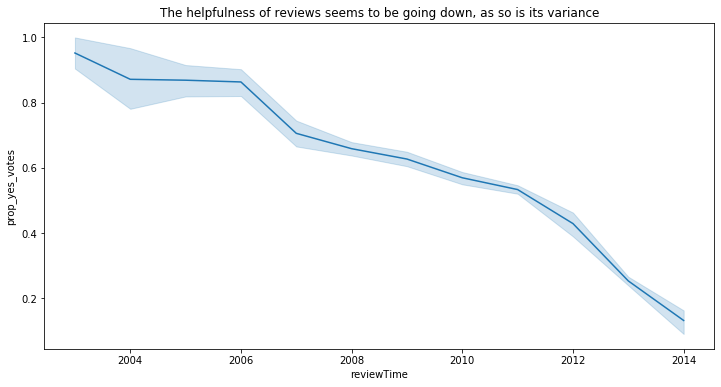

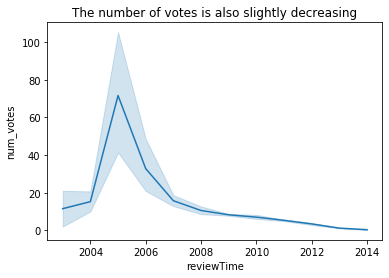

In [111]:
# Specify that we want a monthly period
period = df["reviewTime"].dt.to_period(freq="M")

# Group every year/month and get the mean of the specified variables
grouped_data = df.groupby(period)[["prop_yes_votes", "num_yes_votes", "num_votes", "num_words"]].mean()

# Sort the index (which is the year/month)
grouped_data = grouped_data.sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=grouped_data.index.year, y=grouped_data.prop_yes_votes)
plt.title("The helpfulness of reviews seems to be going down, as so is its variance")
plt.show()

sns.lineplot(x=grouped_data.index.year, y=grouped_data.num_votes)
plt.title("The number of votes is also slightly decreasing")
plt.show()

It does seem that the helpfulness of reviews is going down with time, along with its variance. This could be explained by the fact that there have also been fewer votes over time in general

## Are helpful reviews longer?

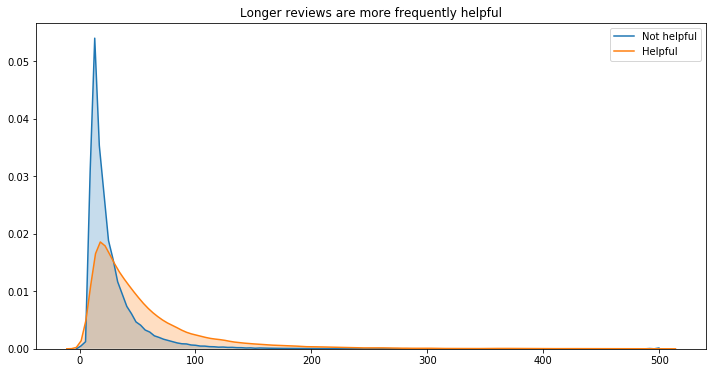

In [124]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df.loc[(df["num_words"] > 0) & (df["num_words"] < 500) & (df["helpful_review"] == 0), "num_words"], shade=True, label="Not helpful")
sns.kdeplot(df.loc[(df["num_words"] > 0) & (df["num_words"] < 500) & (df["helpful_review"] == 1), "num_words"], shade=True, label="Helpful")
plt.title("Longer reviews are more frequently helpful")
plt.show()

This shows us that all reviews are generally short (they have a median of 20 meaningful words), but it is a little bit more frequent to find longer reviews being helpful than otherwise

## What are the most frequent words in helpful messages?

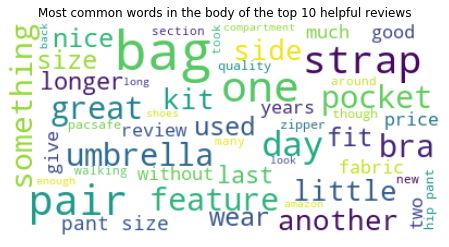

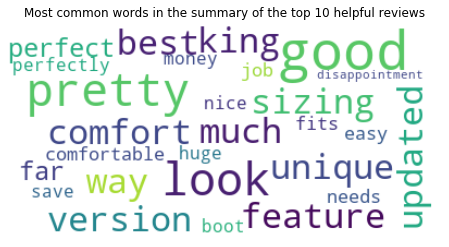

In [202]:
from wordcloud import WordCloud

def plot_wordcloud(column, plot_title=""):
    """
        Plot the wordcloud of the concatenated string from the provided column
        Arguments:
            column: The column of interest to be concatenated
            plot_title: the title of the plot
    """
    # Concatenate the string column 
    try:
        concatenated_str = " ".join(helpful_reviews[column].to_numpy())
    except:
        print("Please pass a valid string column name")
        concatenated_str = ""
    
    # Create the word cloud
    wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", random_state=42)\
        .generate(concatenated_str)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(plot_title)
    plt.axis("off")
    plt.show()
    
plot_wordcloud("reviewText", plot_title="Most common words in the body of the top 10 helpful reviews")
plot_wordcloud("summary", plot_title="Most common words in the summary of the top 10 helpful reviews")

What this tells us that the the top 10 reviews are generally positive reviews (which goes along with what is concluded in the correlation matrix analysis) but interestingly enough in the body of the review people tend to describe the product and dont use so many words as "great", "good", etc. It seems that it might be the fact that people (at least in these 10 reviews) use the summary to express their sentiment towards the item, and in the body of the review they describe why.

## Conclusion of these analysis:

With these preliminary analysis we conclude that:
- There exists some correlation between the overall score of a product and the helpfulness of a review, at least for reviews that have votes in them
- Reviews that have votes generally have a median of 2 votes
- Reviews tend to be getting less helpful over time, however so is the number of votes reviews get
- Helpful reviews are slightly longer than non-helpful reviews
- People tend to use the summary to express their feelings towards the item and the body of the review to describe it

# Task 2. Modeling